<h1> Robot Navigation Project </h1>

In [3]:
## referencies:
# http://vision.deis.unibo.it/~smatt/Papers/VI2002/VI2002.pdf

<h3> Libraries and Global Variables </h3>

In [4]:
f = 567.2 # focal length in pixel
b = 92.226 # base line in mm
cb_w = 125 # chessboard total width in  mm
cb_h = 178 # chessboard total height in mm
pattern_size = (6, 8) # number of inner corner, (columns, rows) of chessboard

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<h3> Extracting image frames from video </h3>

In [6]:
roboL = cv2.VideoCapture('./robotL.avi')
roboL_frames = []

while roboL.isOpened():
    ret, frame = roboL.read()
    if not ret:
        break
    roboL_frames = roboL_frames + [frame]

In [7]:
roboR = cv2.VideoCapture('./robotR.avi')
roboR_frames = []

while roboR.isOpened():
    ret, frame = roboR.read()
    if not ret:
        break
    roboR_frames = roboR_frames + [frame]

In [8]:
print("No. of frames for left camera : ", len(roboL_frames))
print("No of frames for right camera : ", len(roboR_frames))

No. of frames for left camera :  389
No of frames for right camera :  389


In [9]:
if len(roboL_frames) != len(roboR_frames):
    print('Error number of frames dos not match')
number_of_frames = len(roboL_frames)
print(number_of_frames)

389


In [10]:
roboL_frames[10].shape

(480, 640, 3)

<h3> Image Processing & Histogram Analysis on single image </h3>

In [11]:
img = roboL_frames[100]

In [12]:
def plot_histogram(image, title, mask=None):
	# split the image into its respective channels, then initialize
	# the tuple of channel names along with our figure for plotting
	chans = cv2.split(image)
	colors = ("b", "g", "r")
	plt.figure()
	plt.title(title)
	plt.xlabel("Bins")
	plt.ylabel("# of Pixels")
	# loop over the image channels
	for (chan, color) in zip(chans, colors):
		# create a histogram for the current channel and plot it
		hist = cv2.calcHist([chan], [0], mask, [256], [0, 256])
		plt.plot(hist, color=color)
		plt.xlim([0, 256])

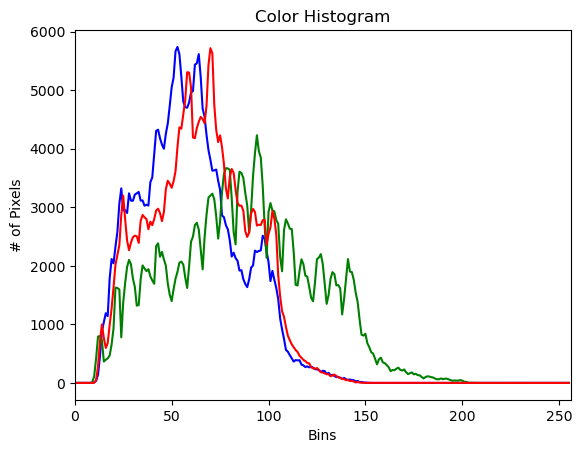

In [13]:
plot_histogram(img, 'Color Histogram')

In [14]:
img_gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray2 = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

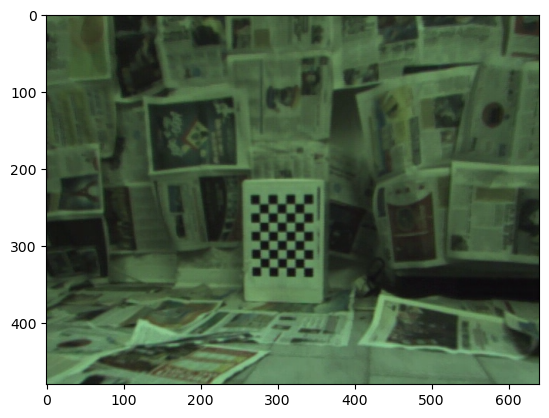

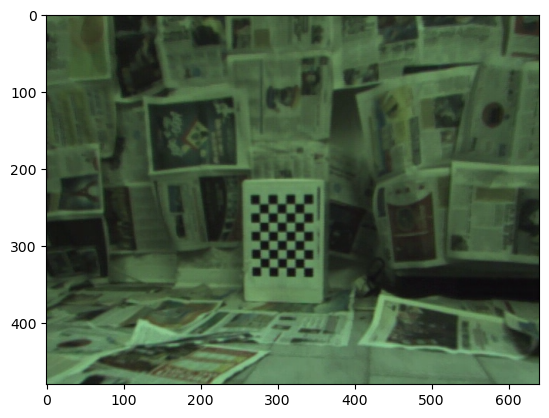

In [15]:
img_x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_x)
plt.show()
img_x = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_x)
plt.show()

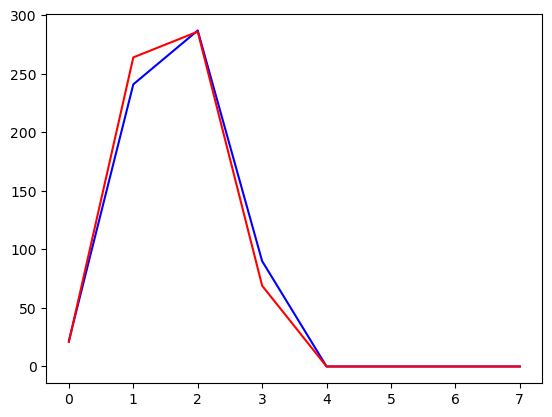

In [16]:
hist1 = cv2.calcHist(img_gray1, [0], None, [8], [0, 256])
hist2 = cv2.calcHist(img_gray2, [0], None, [8], [0, 256])
plt.plot(hist1, 'b')
plt.plot(hist2, 'r')
plt.show()

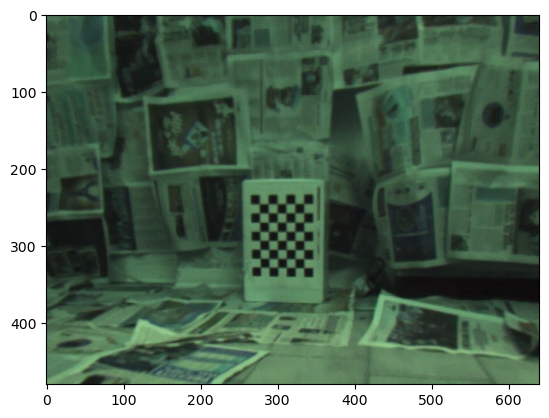

In [17]:
plt.imshow(img)
plt.show()

<h3> Converting to NumPy Array </h3>


In [18]:
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)

<h2> Cropping </h2>

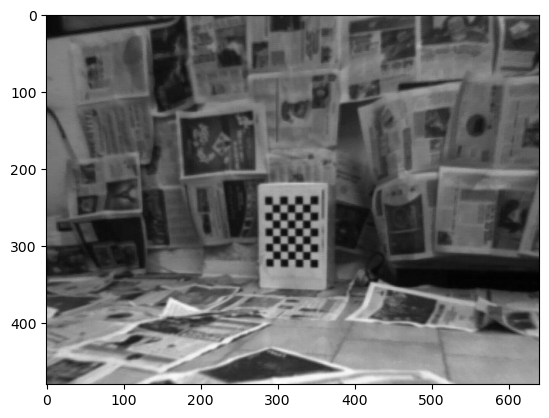

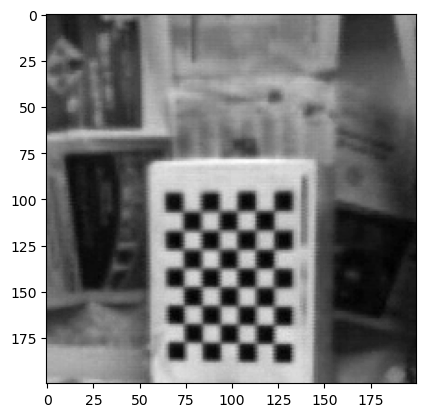

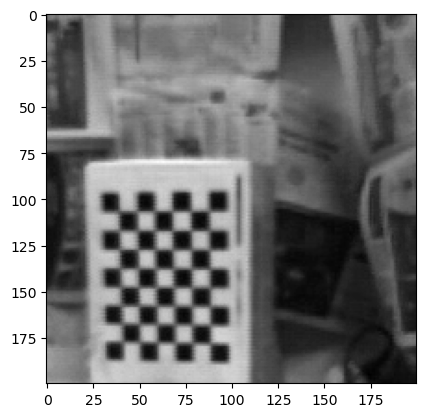

uint8
uint8


(389, 480, 640)

In [19]:
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY) for frame in np_R])
framenumber = 200

Box_size=200
sq_area_side=int(Box_size/2)
offset = 0
frame_height = np_L_gray.shape[1]
frame_width = np_L_gray.shape[2]

np_L_cropped=np_L_gray[framenumber,int(frame_height/2)-sq_area_side:int(frame_height/2)+sq_area_side,int(frame_width/2)-sq_area_side:int(frame_width/2)+sq_area_side]
np_R_cropped=np_R_gray[framenumber,int(frame_height/2)-sq_area_side:int(frame_height/2)+sq_area_side,int(frame_width/2)-sq_area_side-offset:int(frame_width/2)+sq_area_side-offset]

# Display the images
plt.imshow(np_L_gray[framenumber], cmap='gray')
plt.show()
# plt.imshow(np_R_gray[framenumber], cmap='gray')
# plt.show()
plt.imshow(np_L_cropped, cmap='gray')
plt.show()
plt.imshow(np_R_cropped, cmap='gray')
plt.show()

print(np_L_cropped.dtype)
print(np_R_cropped.dtype)

np_L_gray.shape

# Disparity map

Mean positive disparity: 32.123957330766764


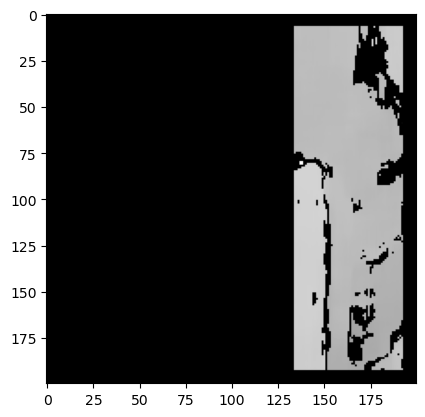

In [20]:
stereo = cv2.StereoBM_create(numDisparities=128, blockSize=15)

# Change the method used by StereoBM (for example, change to SSD)
#stereo.setPreFilterType(cv2.STEREO_BM_NARROW_PRESET)
 #   cv2.STEREO_BM_BASIC_PRESET: Normalized Sum of Absolute Differences (SAD)
  #  cv2.STEREO_BM_FISH_EYE_PRESET: Fish-eye distortion tolerant SAD
   # cv2.STEREO_BM_NARROW_PRESET: Normalized Sum of Squared Differences (SSD)
    #cv2.STEREO_BM_XSOBEL: Cross-based matching algorithm using the Sobel operator
    # cv2.STEREO_BM_LS: Locally supported matching algorithm (LS)

disparity = stereo.compute(np_L_cropped,np_R_cropped)

disparity=disparity/16
plt.imshow(disparity,'gray')

# Filter out positive disparity values
positive_disparities = disparity[disparity > 0]

# Calculate mean of positive disparities
mean_disparity = np.mean(positive_disparities)

print("Mean positive disparity:", mean_disparity)

In [21]:
d_main = mean_disparity + offset
z_mm = f*b/d_main
z_mm

1628.397979158672

Mean positive disparity: 32.123957330766764
Distance in mm: 1623.0241091352752


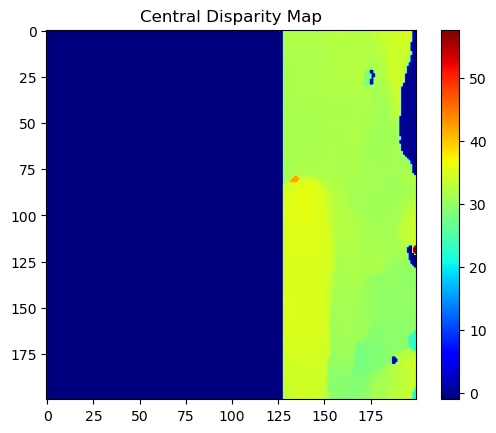

In [22]:
minDisparity=0                  # Minimum possible disparity value
numDisparities=128                # Range of disparity (maxDisparity - minDisparity)
blockSize=21                     # Size of the window used for matching (odd values only)
P1=0                             # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0               # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0              # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

stereo = cv2.StereoSGBM_create(minDisparity,numDisparities,blockSize,P1,P2,disp12MaxDiff,preFilterCap,uniquenessRatio,speckleWindowSize,speckleRange,mode)
disparity = stereo.compute(np_L_cropped,np_R_cropped)
#disparity_map = cv2.normalize(disparity_map, disparity_map, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

disparity=disparity/16

# Filter out positive disparity values
positive_disparities = disparity[disparity > 0]

# Calculate mean of positive disparities
d_main = np.mean(positive_disparities)

print("Mean positive disparity:", mean_disparity)

z_mm = f*b/d_main
print("Distance in mm:", z_mm)

plt.imshow(disparity, cmap='jet')
plt.colorbar()
plt.title(f'Central Disparity Map')
plt.show()

<h3> Detecting Chessboard Pattern (Single Image)</h3>

In [23]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV

In [24]:
found, corners = cv2.findChessboardCorners(img_gray1, pattern_size)
print("Found: " , found)
print("2D image coordinate of corners: ", corners)

Found:  True
2D image coordinate of corners:  [[[276.77643 247.1833 ]]

 [[288.34442 246.24152]]

 [[300.23627 246.1392 ]]

 [[311.06436 245.73996]]

 [[322.5864  246.46198]]

 [[334.53333 246.01067]]

 [[277.4241  258.45352]]

 [[288.36777 258.61804]]

 [[300.2728  258.44012]]

 [[311.5822  257.81454]]

 [[322.94647 258.50693]]

 [[334.7256  258.35684]]

 [[277.58463 270.1731 ]]

 [[288.76236 270.2757 ]]

 [[300.45737 270.48715]]

 [[311.70044 270.52765]]

 [[322.75998 270.51468]]

 [[334.67145 270.61746]]

 [[277.97617 282.36536]]

 [[288.80505 282.58575]]

 [[300.47955 281.97552]]

 [[311.71667 282.5574 ]]

 [[322.92142 282.3305 ]]

 [[334.5188  282.42157]]

 [[278.094   293.49518]]

 [[289.37146 293.67734]]

 [[300.1503  293.78873]]

 [[311.84204 293.9367 ]]

 [[323.49518 294.0064 ]]

 [[334.5832  294.02924]]

 [[278.02307 305.50446]]

 [[289.44888 305.51715]]

 [[300.4255  305.6942 ]]

 [[312.06424 305.9823 ]]

 [[323.64902 306.12842]]

 [[334.71533 306.0364 ]]

 [[277.6871  317.4

In [25]:
corners.shape

(48, 1, 2)

In [26]:
# Do cornerSubPix only if chessboard found is True
if found:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(img_gray1, corners, (5, 5), (-1, -1), term)
    print("Found")
else:
    print("Not Found")

Found


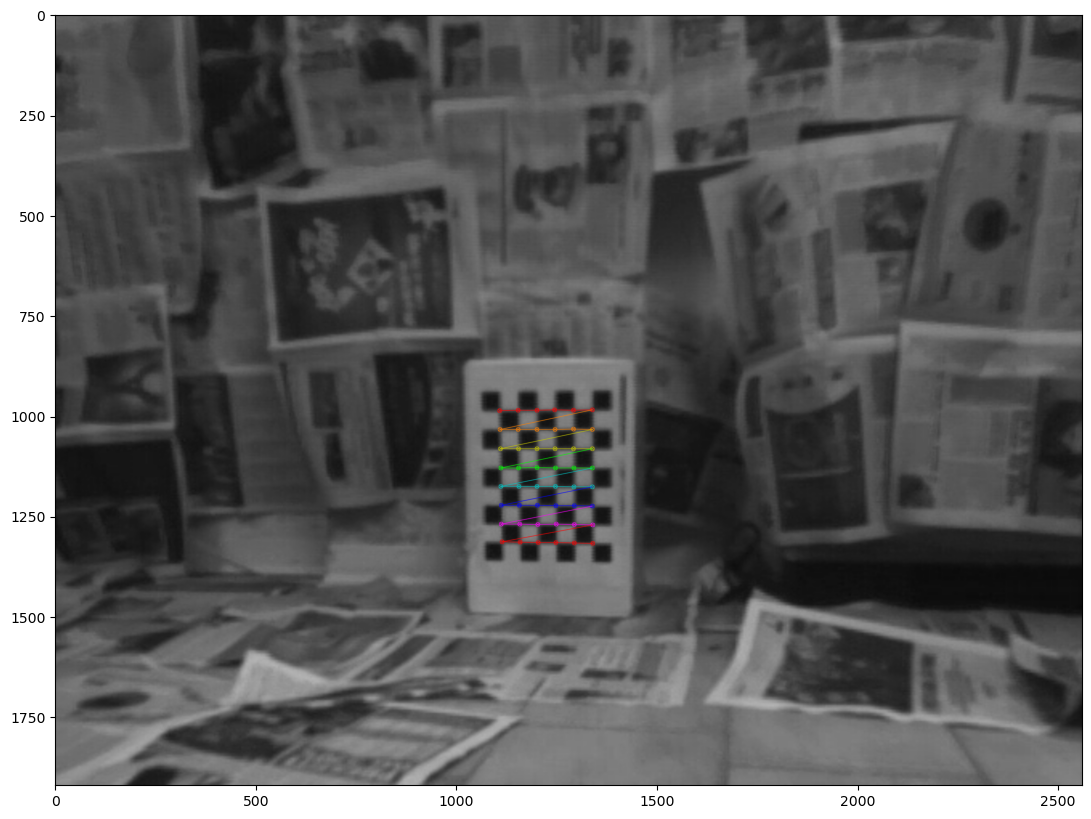

In [27]:
vis = cv2.cvtColor(img_gray1, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, corners*4, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

# Computing distance of the camera from the chessboard referred to specific frame 

In [28]:
imgL = roboL_frames[100]
imgR = roboR_frames[100]
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

In [29]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
foundL, cornersL = cv2.findChessboardCorners(imgL_gray, pattern_size)
foundR, cornersR = cv2.findChessboardCorners(imgR_gray, pattern_size)

# Do cornerSubPix only if chessboard found is True
if foundL and foundR:
    #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
    term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
    #Image Corners 
    cv2.cornerSubPix(imgL_gray, cornersL, (5, 5), (-1, -1), term)
    cv2.cornerSubPix(imgR_gray, cornersR, (5, 5), (-1, -1), term)

print("Found: " , foundL)
print("Found: " , foundR)
#print("2D image coordinate of corners: ", cornersL)
#print("2D image coordinate of corners: ", cornersR)

Found:  True
Found:  True


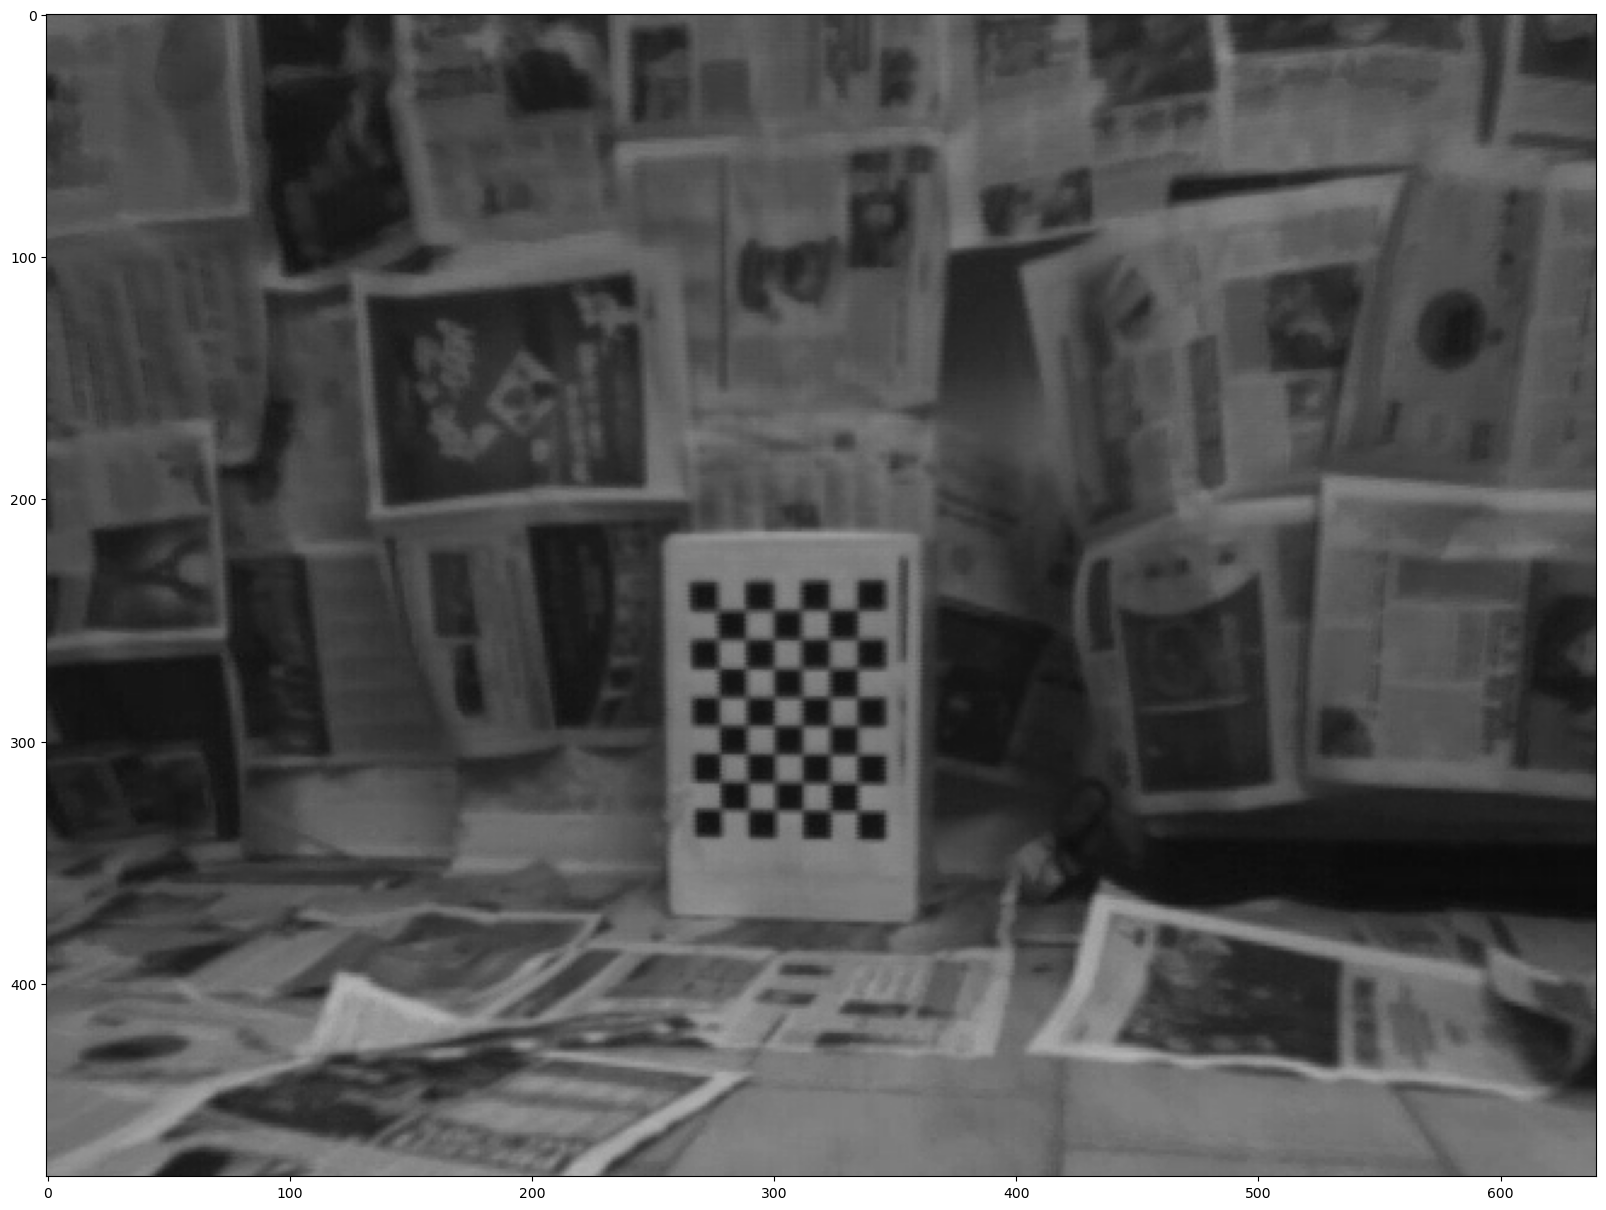

In [30]:
# To check correctness of coordinates
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

fig = plt.figure(figsize=(20,30))

def onclick(event):
    ix, iy = event.xdata, event.ydata
    print("Coordinate clicked pixel (row,column): [{},{}]".format(int(round(ix)), int(round(iy))))

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(cv2.cvtColor(imgL_gray, cv2.COLOR_BGR2RGB))
plt.show()

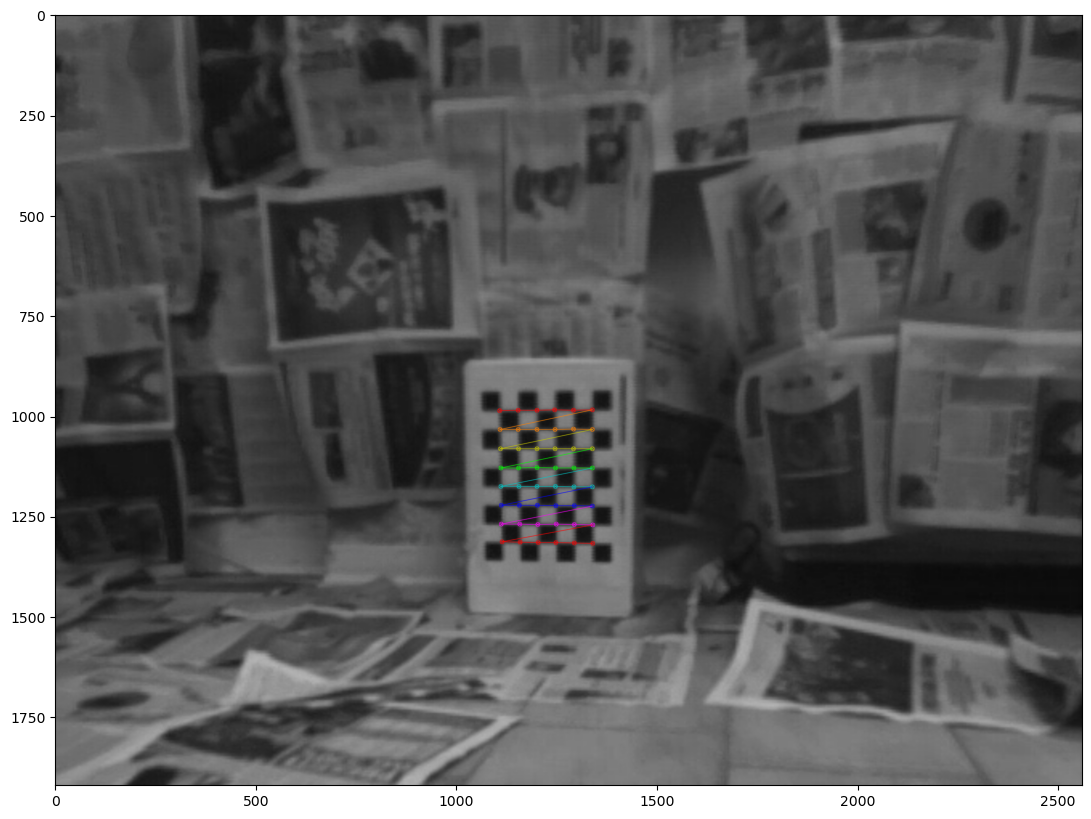

In [31]:
vis = cv2.cvtColor(imgL_gray, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, cornersL*4, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

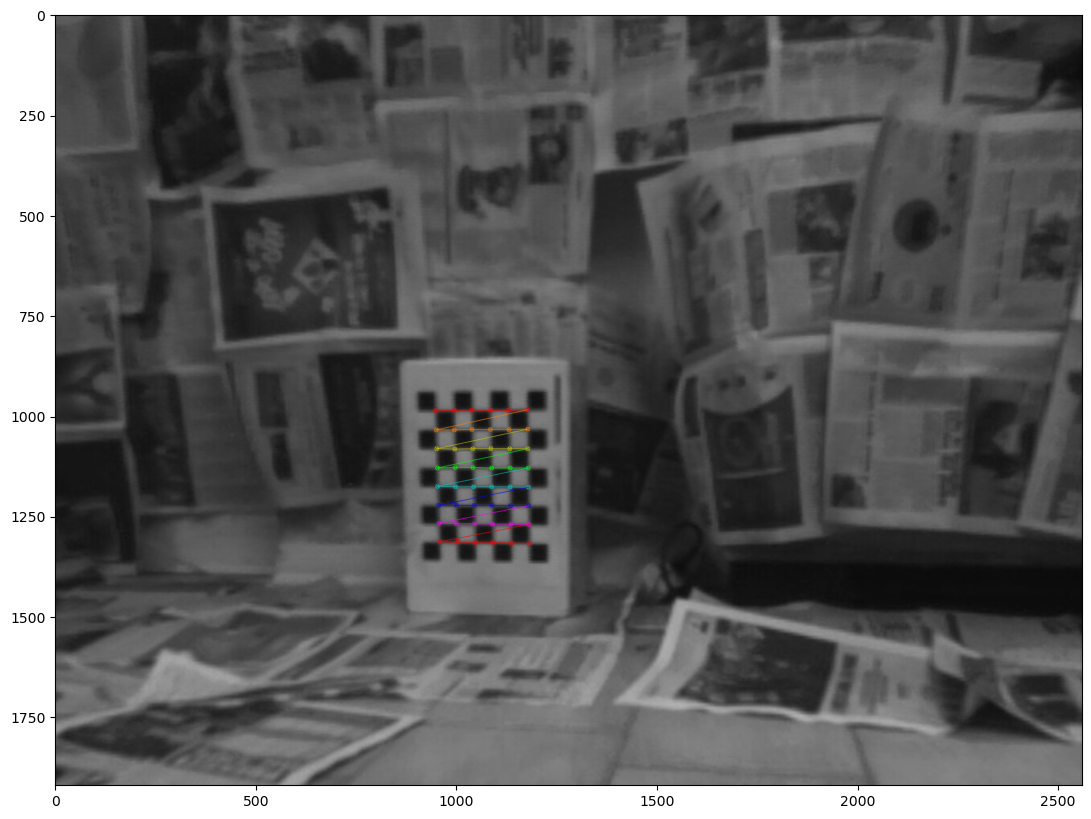

In [32]:
vis = cv2.cvtColor(imgR_gray, cv2.COLOR_GRAY2BGR)
vis = cv2.resize(vis,None,fx=4, fy=4)
cv2.drawChessboardCorners(vis, pattern_size, cornersR*4, found)
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.show()

In [33]:
Lxi = [elem[0][0] for elem in cornersL]
Rxi = [elem[0][0] for elem in cornersR]
print(Lxi) 
print(Rxi)

[276.92728, 288.51187, 300.20468, 311.33182, 322.9879, 334.66174, 277.2161, 288.53366, 300.17303, 311.5126, 323.00702, 334.67432, 277.41953, 288.64554, 300.26486, 311.60876, 323.05637, 334.69974, 277.68854, 288.85208, 300.36777, 311.8518, 323.20172, 334.7108, 277.85178, 289.04422, 300.37253, 311.86093, 323.3611, 334.77222, 278.02557, 289.1917, 300.58997, 312.06073, 323.39685, 334.7588, 278.0144, 289.5741, 300.652, 312.15082, 323.4769, 334.87503, 278.38403, 289.63144, 300.92438, 312.0662, 323.55325, 334.88135]
[236.79779, 248.71585, 259.58905, 271.24503, 282.61118, 294.19067, 237.381, 248.77657, 259.80734, 271.37018, 282.68024, 294.3914, 237.6592, 249.02568, 260.1336, 271.6233, 283.15085, 294.48, 238.15526, 249.32541, 260.3098, 271.9568, 283.47504, 294.70114, 238.30907, 249.51314, 260.63638, 272.1152, 283.53473, 294.94266, 238.93463, 249.93488, 261.28827, 272.32593, 283.81818, 295.02402, 239.15953, 250.10374, 261.49365, 272.562, 283.95096, 295.2841, 239.68327, 250.40407, 261.88556, 272.

In [34]:
diffs = []
for l, r in zip(Lxi, Rxi):
    diff = l - r
    diffs.append(diff)

d = sum(diffs)/len(diffs)

print(diffs)
print("disparity:", d)

[40.129486, 39.79602, 40.61563, 40.086792, 40.37674, 40.47107, 39.8351, 39.757095, 40.365692, 40.142426, 40.326782, 40.28293, 39.76033, 39.619858, 40.131256, 39.985474, 39.905518, 40.219727, 39.53328, 39.526672, 40.057953, 39.89502, 39.726685, 40.009644, 39.54271, 39.531082, 39.736145, 39.745728, 39.826385, 39.82956, 39.090942, 39.256836, 39.301697, 39.734802, 39.578674, 39.73477, 38.854874, 39.470352, 39.158356, 39.588806, 39.52594, 39.590942, 38.70076, 39.22737, 39.03882, 39.282623, 39.35135, 39.574768]
disparity: 39.7256555557251


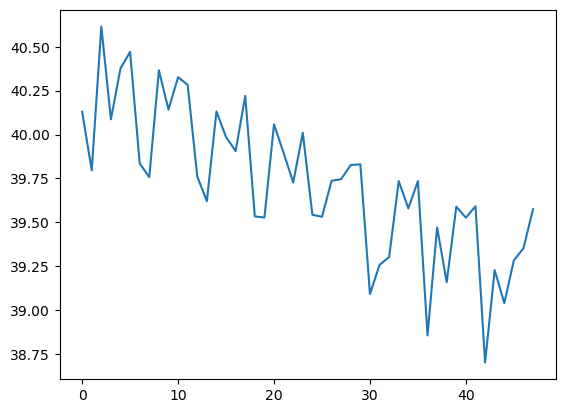

In [35]:
plt.plot(diffs)

<h2>INTERESTING</h2>

In [36]:
z = (b * f)/d 
print("Distance of the obstacle (mm):",z)

Distance of the obstacle (mm): 1316.7960721660443


# Numpy Array for frames

In [37]:
np_L = np.array(roboL_frames)
np_R = np.array(roboR_frames)
np_L_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in np_L])
np_R_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in np_R])

# computing distances of the camera from the chessboard during the whole video by uing Chessboard corner


In [38]:
pattern_size = (6, 8) # number of inner corner, (columns, rows) for OpenCV
list_foundL = []
list_cornersL = []

progress = 0
for frame in np_L_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundL.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersL.append(corners)
    else:
        print("not found", progress, end=', ')
        #list_foundL.append(None)
        list_cornersL.append(None)
    
        

print("job completed")

not found 1, 2, not found 3, 4, not found 5, not found 6, 7, 8, 9, 10, not found 11, not found 12, not found 13, not found 14, not found 15, not found 16, not found 17, 18, 19, 20, 21, not found 22, not found 23, 24, not found 25, not found 26, not found 27, 28, 29, 30, 31, 32, not found 33, not found 34, not found 35, not found 36, not found 37, 38, 39, 40, not found 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172

In [39]:
list_foundR = []
list_cornersR = []

progress = 0
for frame in np_R_gray:
    found, corners = cv2.findChessboardCorners(frame, pattern_size)
    list_foundR.append(found)
    
    progress+=1
    if found:
        #Refining corner position to subpixel iteratively until criteria max_count=30 or criteria_eps_error=1 is sutisfied
        term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 1)
        #Image Corners 
        cv2.cornerSubPix(frame, corners, (5, 5), (-1, -1), term)
        print(progress, end=', ')
        list_cornersR.append(corners)
    else:
        print("not found", progress, end=', ')
        list_cornersR.append(None)

print("job completed")

1, 2, not found 3, 4, 5, 6, 7, 8, 9, 10, not found 11, 12, not found 13, 14, 15, not found 16, not found 17, not found 18, not found 19, 20, not found 21, not found 22, 23, 24, not found 25, not found 26, not found 27, not found 28, 29, not found 30, not found 31, not found 32, not found 33, not found 34, not found 35, not found 36, 37, 38, not found 39, 40, 41, not found 42, not found 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, not found 70, not found 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172

In [40]:
list_Lxi = []
list_Rxi = []

for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        Lxi_frame = [elem[0][0] for elem in list_cornersL[frame]]
        Rxi_frame = [elem[0][0] for elem in list_cornersR[frame]]
        list_Lxi.append(Lxi_frame)
        list_Rxi.append(Rxi_frame)
    else:
        list_Lxi.append(None)
        list_Rxi.append(None)

In [41]:
print(len(list_Rxi))

389


In [42]:
list_d = []
for frame in range(number_of_frames):
    diffs = []
    if list_foundL[frame] and list_foundR[frame]:
        for l, r in zip(list_Lxi[frame], list_Rxi[frame]):
            diff = l - r
            diffs.append(diff)
        d = sum(diffs)/len(diffs)
        list_d.append(d)
    else:
        list_d.append(None)

In [43]:
list_z = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        z = (b * f)/list_d[frame]
        list_z.append(z)
    else:
        list_z.append(None)

In [44]:
print(list_d[100])
print(list_z[100])

39.7256555557251
1316.7960721660443


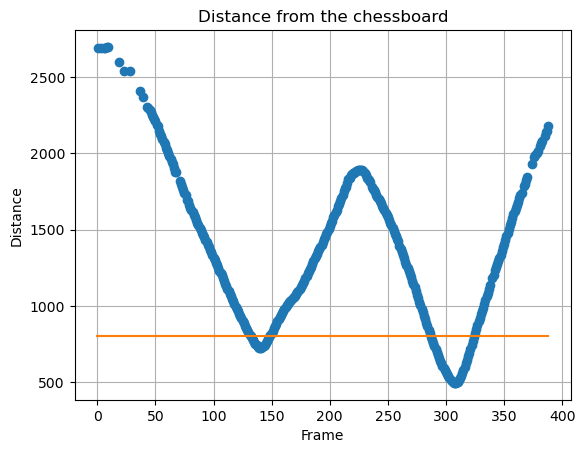

In [45]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [46]:
from math import cos

W_mm_list = []
H_mm_list = []
W_mm_diff = []
H_mm_diff = []
w_px_list = []
h_px_list = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        w_px = 0
        h_px = 0
        for w_line in range(8):
            w_px_R = list_cornersR[frame][6*w_line+5][0][0]-list_cornersR[frame][6*w_line+0][0][0]
            w_px_L = list_cornersL[frame][6*w_line+5][0][0]-list_cornersL[frame][6*w_line+0][0][0]
            w_px = w_px+w_px_L+w_px_R
        for h_line in range(6):
            h_px_R = list_cornersR[frame][42+h_line][0][1]-list_cornersR[frame][0+h_line][0][1]
            h_px_L = list_cornersL[frame][42+h_line][0][1]-list_cornersL[frame][0+h_line][0][1]
            h_px = h_px+h_px_L+h_px_R
       
        w_px = w_px/16
        h_px = h_px/12
        W_mm = w_px*list_z[frame]/f     
        H_mm = h_px*list_z[frame]/f   
        w_px_list.append(w_px)
        h_px_list.append(h_px) 
        W_mm_diff.append(W_mm-125)
        H_mm_diff.append(H_mm-175)
    else:
        w_px_list.append(None)
        h_px_list.append(None)
        W_mm_diff.append(None)
        H_mm_diff.append(None)
    

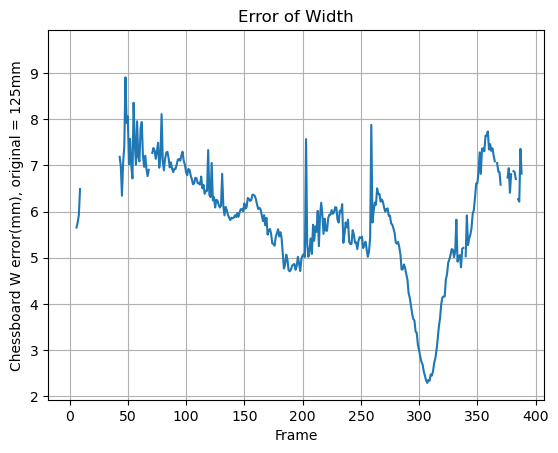

In [47]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, W_mm_diff)
plt.title('Error of Width')
plt.xlabel('Frame')
plt.ylabel('Chessboard W error(mm), original = 125mm')
plt.grid(True)
plt.show()

<h3> Computing distances of the central area of the frames during the whole video by using Disparity map </h3>


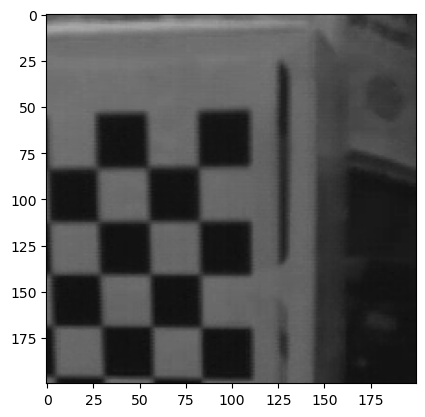

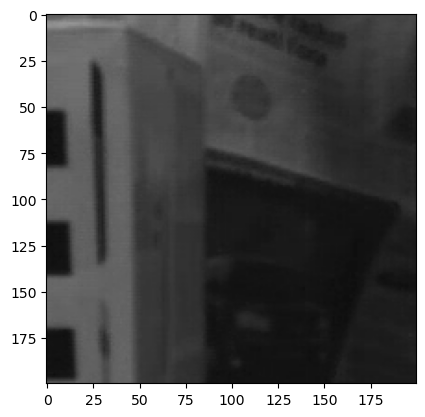

In [48]:
list_L_cropped = []
list_R_cropped = []

Box_size=200
sq_area_side=int(Box_size/2)
offset = 0

Frame_height=np_L_gray.shape[1]
Frame_width=np_L_gray.shape[2]

for framenumber in range(number_of_frames):
    np_L_cropped=np_L_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side:int(Frame_width/2)+sq_area_side]
    np_R_cropped=np_R_gray[framenumber,int(Frame_height/2)-sq_area_side:int(Frame_height/2)+sq_area_side,int(Frame_width/2)-sq_area_side-offset:int(Frame_width/2)+sq_area_side-offset]
    list_L_cropped.append(np_L_cropped)
    list_R_cropped.append(np_R_cropped)

plt.imshow(cv2.cvtColor(list_L_cropped[300], cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(list_R_cropped[300], cv2.COLOR_BGR2RGB))
plt.show()

In [49]:
list_mean_disparity = []

numDisparities=128;
blockSize=21;

stereo = cv2.StereoBM_create(numDisparities, blockSize)

for framenumber in range(number_of_frames):
    disparity = stereo.compute(list_L_cropped[framenumber],list_R_cropped[framenumber])
    positive_disparities = disparity[disparity > 0]
    disparity_px=(positive_disparities/16)
    
    
    mean_disparity = np.mean(disparity_px)

    
    list_mean_disparity.append(mean_disparity)
    print("d_mean:", mean_disparity,"frame:", framenumber)


#plt.imshow(disparity,'gray')
#plt.show()

d_mean: 20.458494182253155 frame: 0
d_mean: 20.464778968339434 frame: 1
d_mean: 20.449415786033338 frame: 2
d_mean: 20.44346743810549 frame: 3
d_mean: 20.485029617662896 frame: 4
d_mean: 20.425432257008836 frame: 5
d_mean: 20.46025929337813 frame: 6
d_mean: 20.423323187452013 frame: 7
d_mean: 20.435228516694036 frame: 8
d_mean: 20.460431850320898 frame: 9
d_mean: 20.464562412266496 frame: 10
d_mean: 20.458875891506377 frame: 11
d_mean: 20.53554410460993 frame: 12
d_mean: 20.55135887913572 frame: 13
d_mean: 20.634362179842554 frame: 14
d_mean: 20.766799919761578 frame: 15
d_mean: 20.79485864745011 frame: 16
d_mean: 20.835492872140566 frame: 17
d_mean: 20.912036270288176 frame: 18
d_mean: 20.986146078102273 frame: 19
d_mean: 21.092283241850566 frame: 20
d_mean: 21.180633940545373 frame: 21
d_mean: 21.177706356212756 frame: 22
d_mean: 21.20035675082327 frame: 23
d_mean: 21.362128327763052 frame: 24
d_mean: 21.50189416360838 frame: 25
d_mean: 21.476936843320633 frame: 26
d_mean: 21.4591855

In [50]:
list_z = []
for framenumber in range(number_of_frames):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z.append(z)

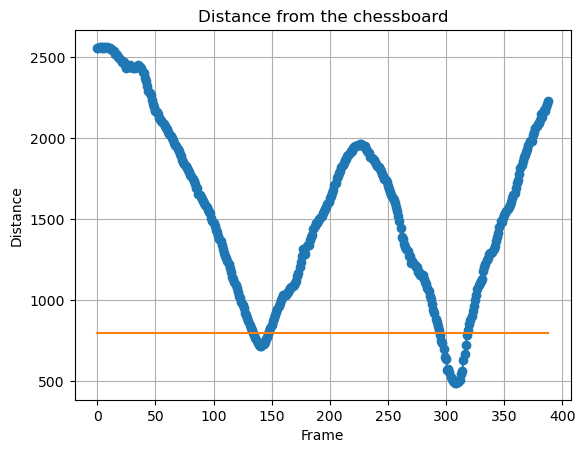

In [51]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z, marker='o', linestyle='-')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

<h3> Disparity Range with Offset </h3>

d_mean: 32.93085405621877 frame: 90


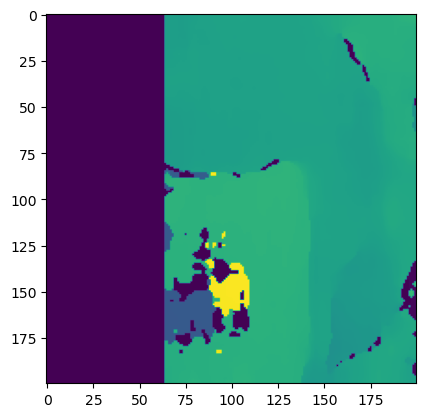

d_mean: 33.5488836691205 frame: 91


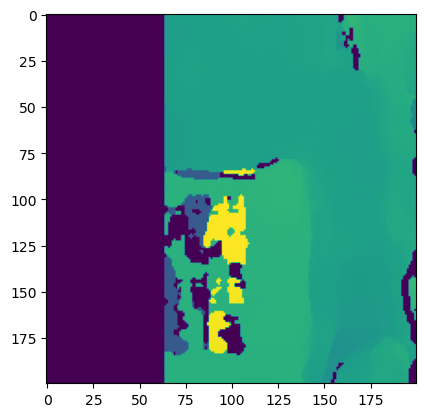

d_mean: 33.48575081673926 frame: 92


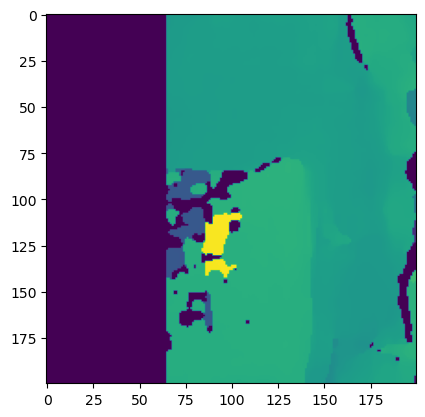

d_mean: 33.47086981932007 frame: 93


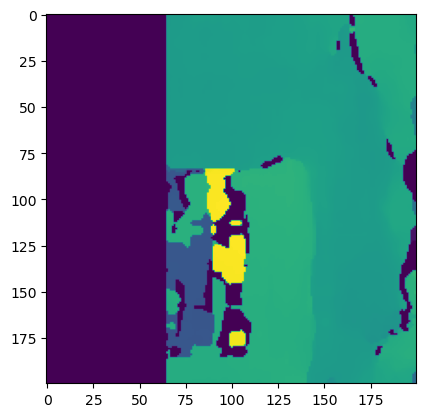

d_mean: 34.4790306501427 frame: 94


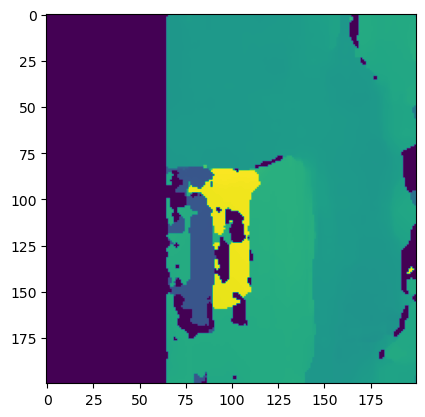

d_mean: 21.9066921875 frame: 95


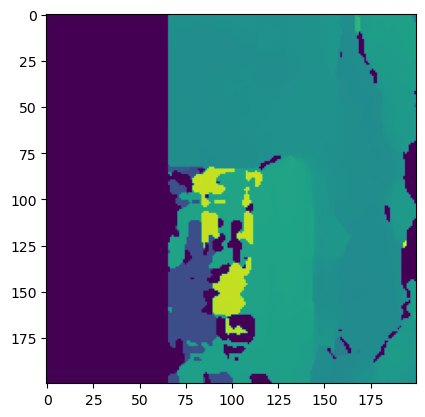

d_mean: 34.88371283903825 frame: 96


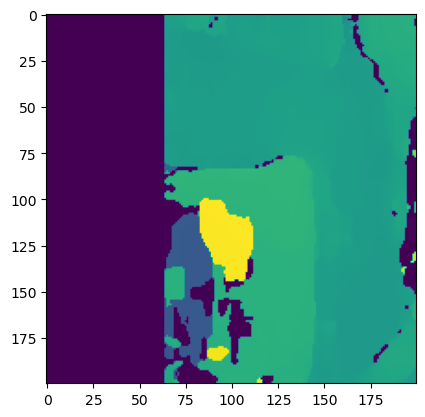

d_mean: 22.6344015625 frame: 97


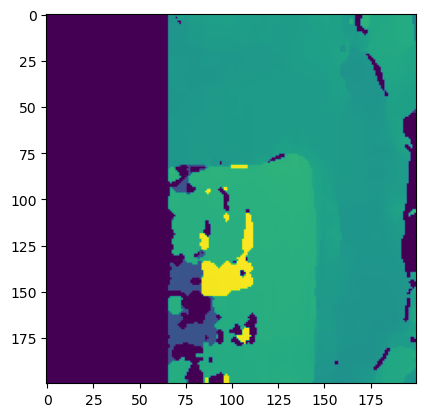

d_mean: 35.610573300816874 frame: 98


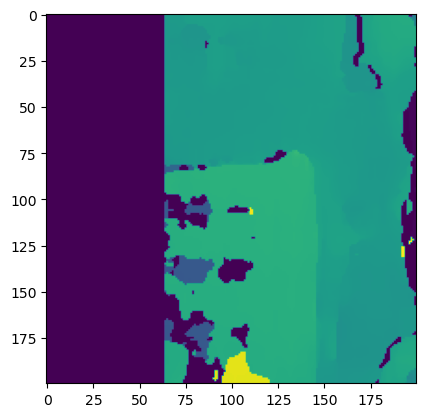

d_mean: 23.05996875 frame: 99


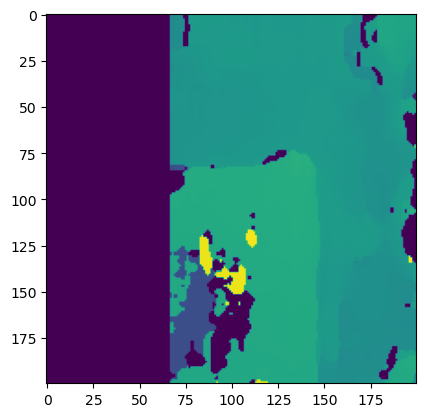

d_mean: 36.626653282947565 frame: 100


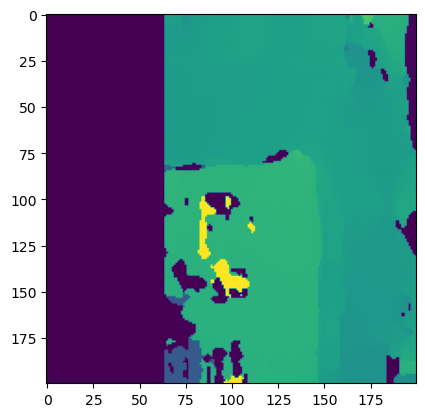

d_mean: 24.9743453125 frame: 101


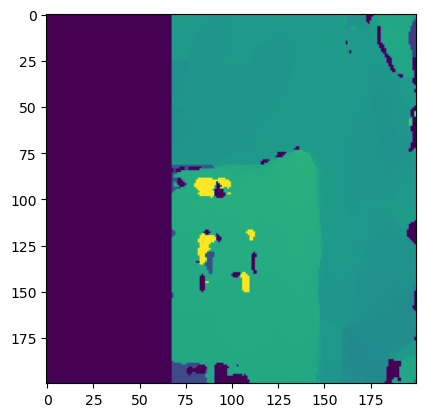

d_mean: 37.31195589368259 frame: 102


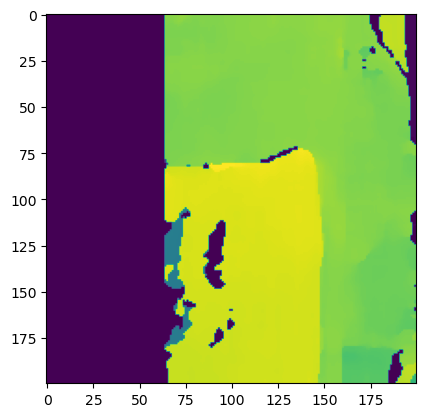

d_mean: 25.4969140625 frame: 103


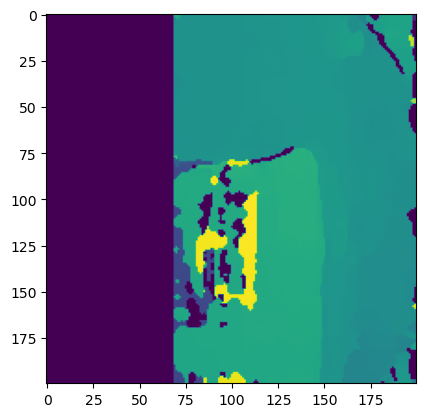

d_mean: 37.992295876965876 frame: 104


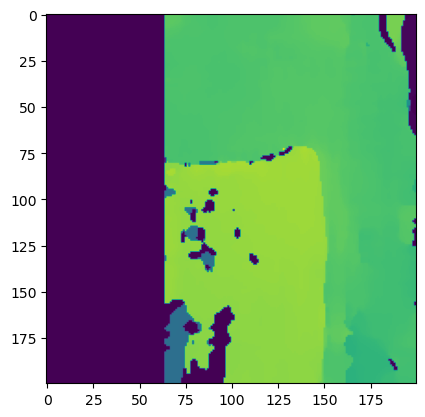

d_mean: 25.7242640625 frame: 105


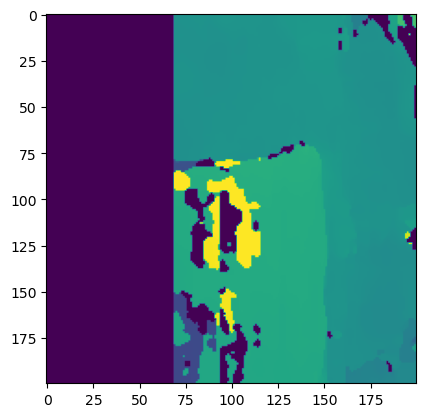

d_mean: 39.42308237830478 frame: 106


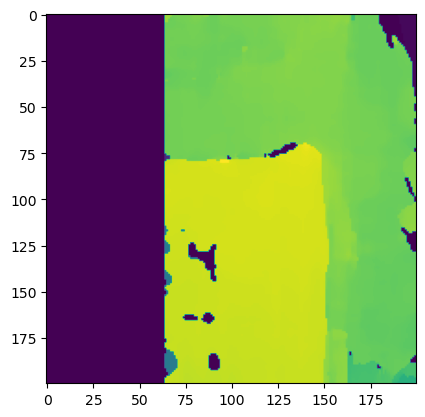

d_mean: 26.710071875 frame: 107


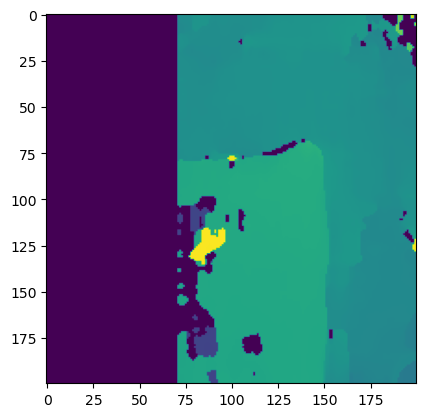

d_mean: 40.06846450113335 frame: 108


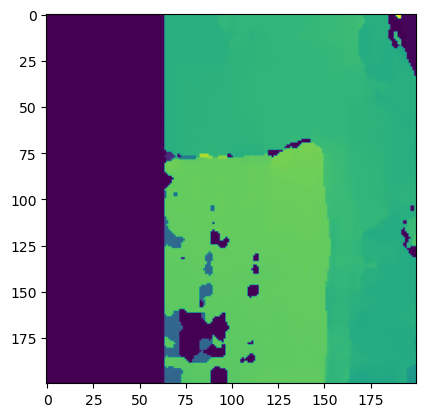

d_mean: 27.730303125 frame: 109


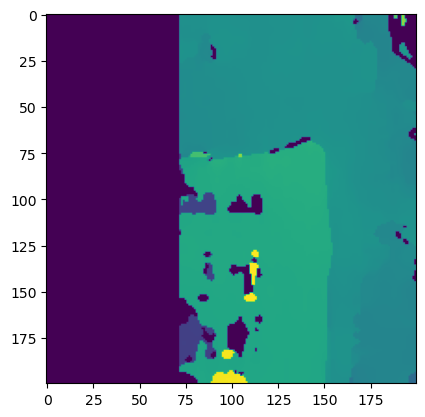

d_mean: 40.682115815498726 frame: 110


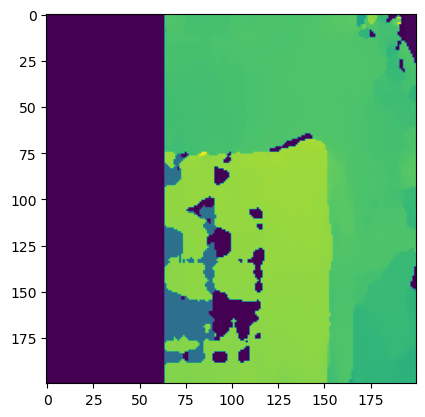

d_mean: 28.5250828125 frame: 111


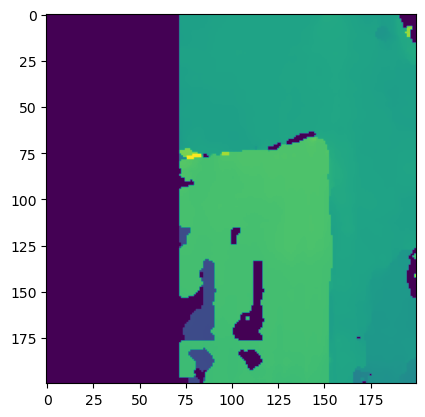

d_mean: 42.070850262317066 frame: 112


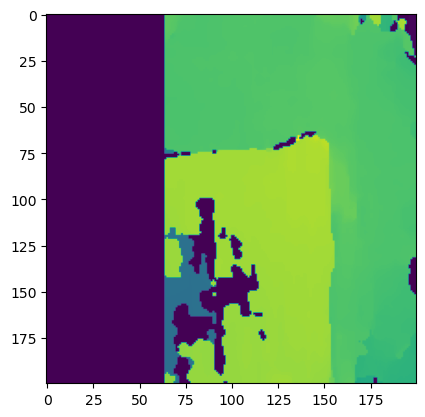

d_mean: 29.6471703125 frame: 113


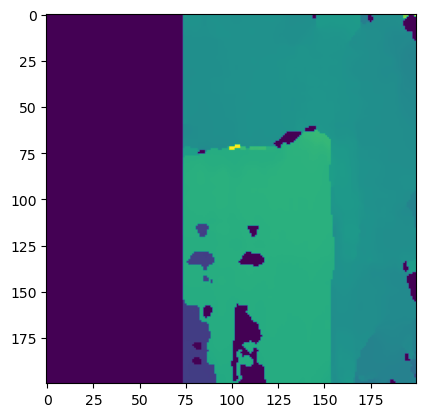

d_mean: 43.827882043935055 frame: 114


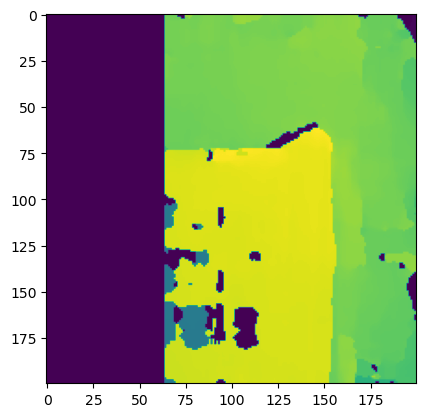

d_mean: 31.0913921875 frame: 115


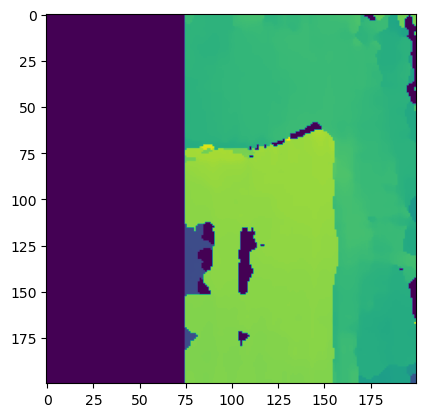

d_mean: 45.00866380324782 frame: 116


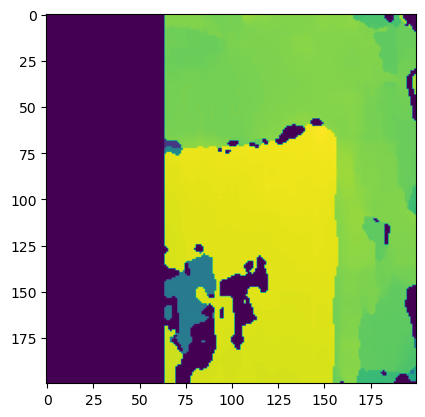

d_mean: 32.766653125 frame: 117


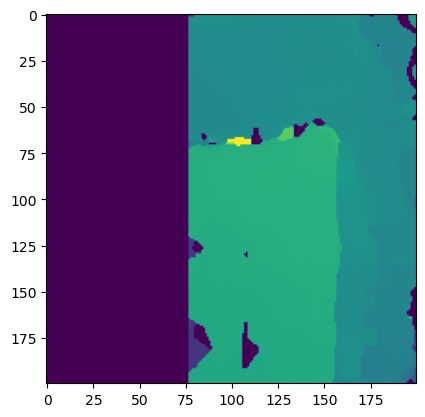

d_mean: 47.35742046960803 frame: 118


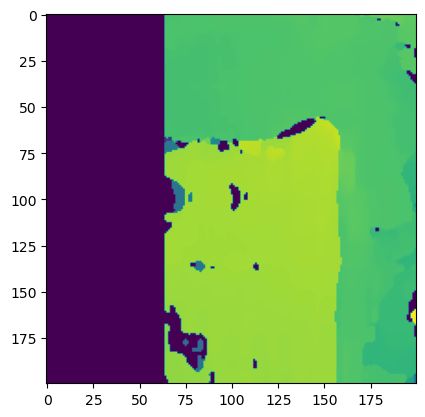

d_mean: 33.887103125 frame: 119


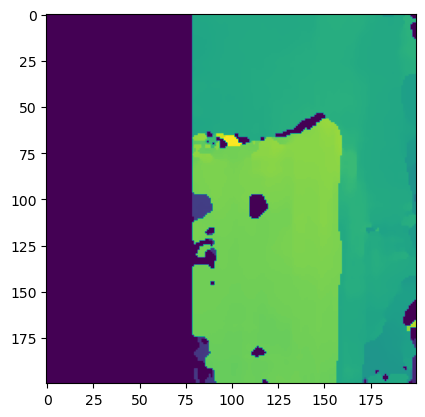

d_mean: 47.5294978373874 frame: 120


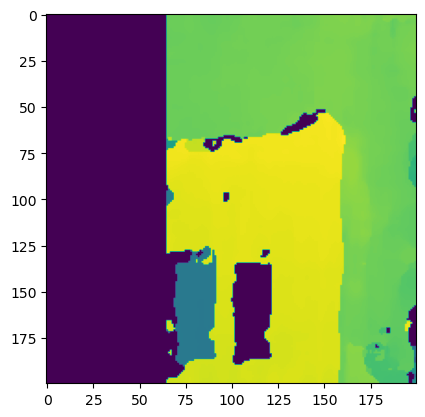

d_mean: 34.7254796875 frame: 121


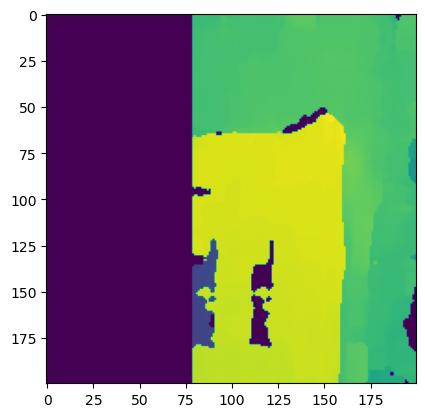

d_mean: 31.7853984375 frame: 122


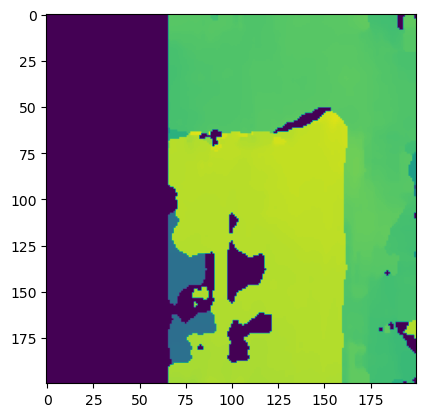

d_mean: 51.16272214956147 frame: 123


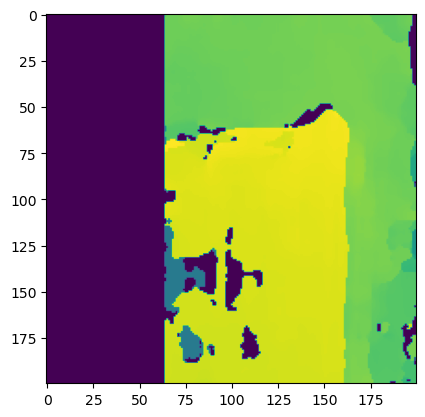

d_mean: 37.7774171875 frame: 124


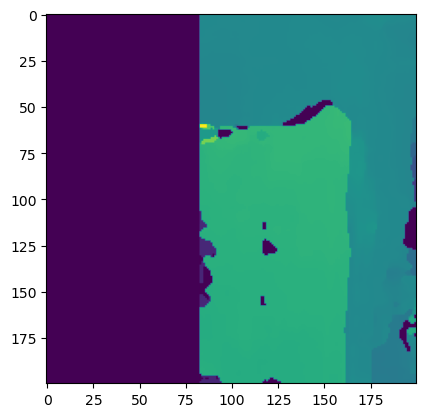

d_mean: 34.55274375 frame: 125


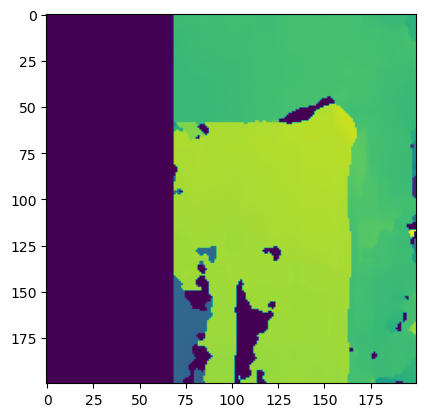

d_mean: 34.2741828125 frame: 126


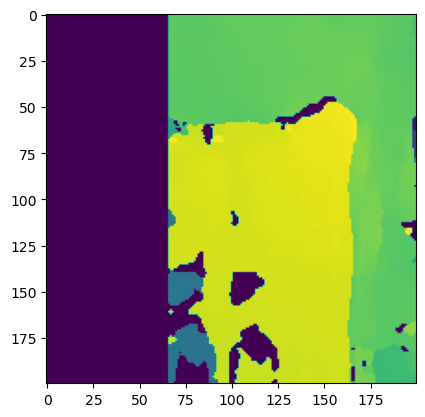

d_mean: 36.051128125 frame: 127


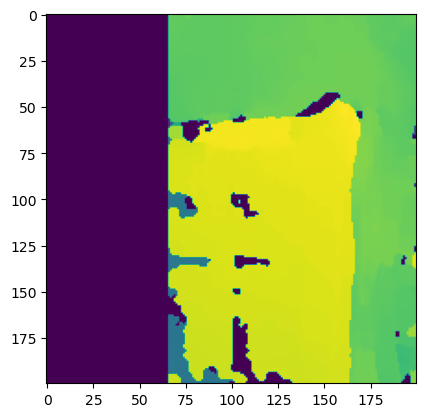

d_mean: 36.8099546875 frame: 128


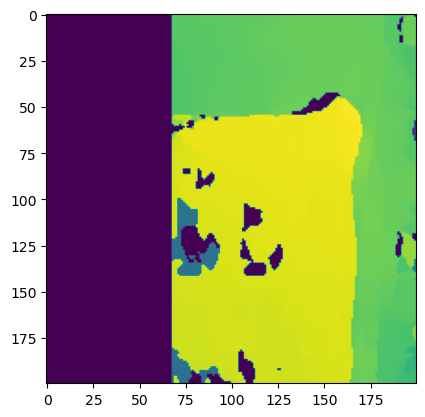

d_mean: 37.565384375 frame: 129


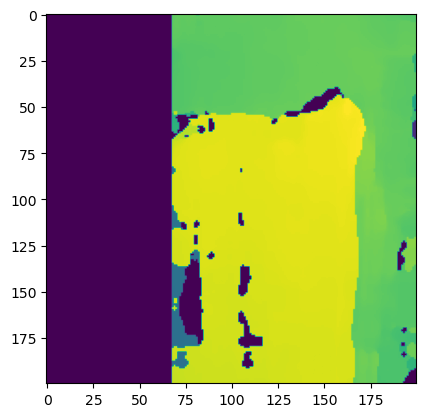

In [83]:
list_mean_disparity = []

disparity_range=64

P1=0                             # Penalty for the first pixel disparity difference
P2=0                             # Penalty for the second pixel disparity difference
disp12MaxDiff=0               # Maximum allowed difference in the left-right disparity check
preFilterCap=0                   # Maximum allowed difference in the left-right disparity check
uniquenessRatio=0              # Margin in percentage by which the best (minimum) computed cost function value should "win"
speckleWindowSize=0              # Maximum size of smooth disparity regions to consider them as a speckle
speckleRange=0                   # Maximum disparity variation within each connected component
mode = 0                         # Set it to StereoSGBM::MODE_HH to run the full-scale two-pass dynamic programming algorithm.

d_main = disparity_range/2
offset_values = []
smoothed_offset_values = []

for framenumber in range(90,130):
    offset = int(d_main - disparity_range/2)
    if offset < 0:
        offset = 0
    if offset > 64:
        offset = 64
    offset_values.append(offset)
    
    # Apply average smoothing filter
    window_size = 1  # Adjust the window size as needed
    if len(offset_values) >= window_size:
        smoothed_offset = sum(offset_values[-window_size:]) / window_size
    else:
        smoothed_offset = offset
    smoothed_offset_values.append(smoothed_offset)
    
    minDisparity = int(smoothed_offset)  # Minimum possible disparity value
    numDisparities = disparity_range  # Range of disparity (maxDisparity - minDisparity)
    blockSize = 21  # Size of the window used for matching (odd values only)
    stereo = cv2.StereoSGBM_create(minDisparity, numDisparities, blockSize, P1, P2, disp12MaxDiff, preFilterCap, uniquenessRatio, speckleWindowSize, speckleRange, mode)
    disparity = stereo.compute(list_L_cropped[framenumber], list_R_cropped[framenumber])
    positive_disparities = disparity[disparity > 0]
    disparity_px = positive_disparities / 16
    
    d_main = np.mean(disparity_px)
    list_mean_disparity.append(d_main)
    print("d_mean:", d_main, "frame:", framenumber)
    plt.imshow(disparity)
    plt.show()



In [75]:
list_z = []
for framenumber in range(40):
        z = (b * f)/list_mean_disparity[framenumber]
        list_z.append(z)

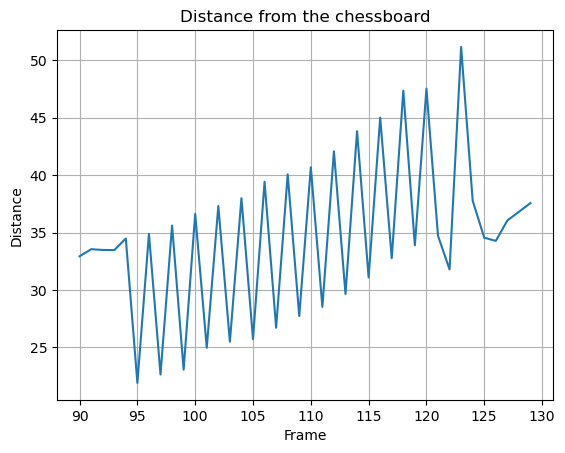

In [77]:
f_values = list(range(90,130))
plt.plot(f_values, list_mean_disparity)
# line = 800*np.ones((len(f_values)))
# plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

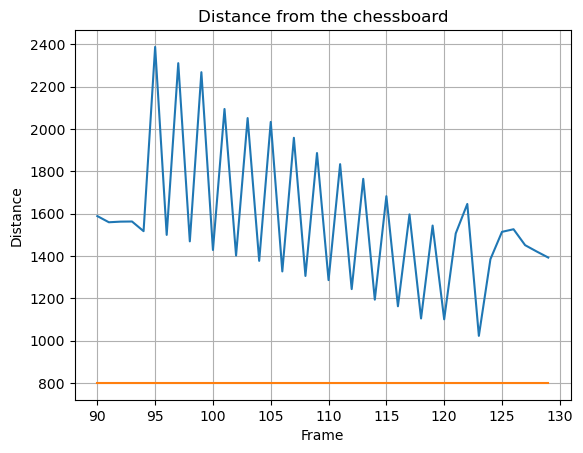

In [78]:
# Plotting
f_values = list(range(90,130))
plt.plot(f_values, list_z)
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.title('Distance from the chessboard')
plt.xlabel('Frame')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

<h3> Splitting the image into vertical strips </h3>

In [ ]:
from math import atan, pi

no_of_strips = 5 #5
strip_width = int(np_L_gray.shape[2]/no_of_strips)

list_mean_disparity = []
list_z_mm = []
list_tau = []

numDisparities=112; #112
blockSize=11; #11

stereo = cv2.StereoBM_create(numDisparities, blockSize)

for framenumber in range(number_of_frames):
    list_frame_disparity = []
    list_frame_z = []
    list_frame_tau = []
    for strip in range(no_of_strips):
        L_img = np_L_gray[framenumber,:,strip*strip_width:(strip+1)*strip_width]
        R_img = np_R_gray[framenumber,:,strip*strip_width:(strip+1)*strip_width]

        disparity = stereo.compute(L_img,R_img)
        # plt.imshow(disparity,'gray')
        # plt.show()
        positive_disparities = disparity[disparity > 0]
        disparity_px=(positive_disparities/16) 
        mean_disparity = np.mean(disparity_px)
        list_frame_disparity = list_frame_disparity + [mean_disparity]
        z_mm = (f*b)/mean_disparity
        list_frame_z = list_frame_z + [z_mm]
        if not(strip==0):
            tau = atan((list_frame_z[strip-1] - z_mm)*f/(strip_width*z_mm))*180/pi
            list_frame_tau = list_frame_tau + [tau]
    list_mean_disparity = list_mean_disparity + [list_frame_disparity]
    avg_z = sum(list_frame_z)/no_of_strips
    #print(list_frame_z, "avg = ", avg_z)
    avg_tau = sum(list_frame_tau)/(no_of_strips-1)
    list_z_mm = list_z_mm + [avg_z]
    list_tau = list_tau + [avg_tau]
        


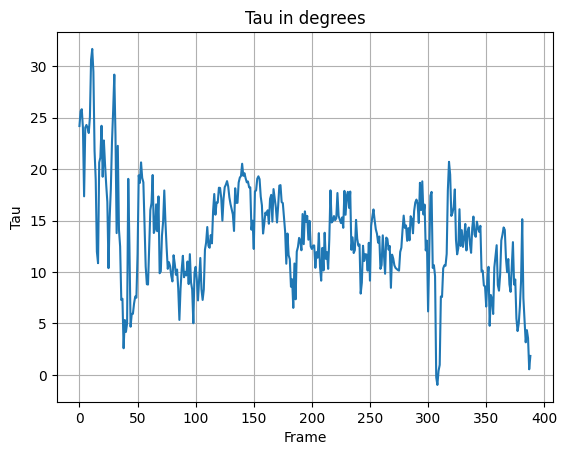

In [ ]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_tau)
plt.title('Tau in degrees')
plt.xlabel('Frame')
plt.ylabel('Tau')
plt.grid(True)
plt.show()

In [ ]:
tau_mean = np.mean(list_tau)
tau_mean

13.523309288423995

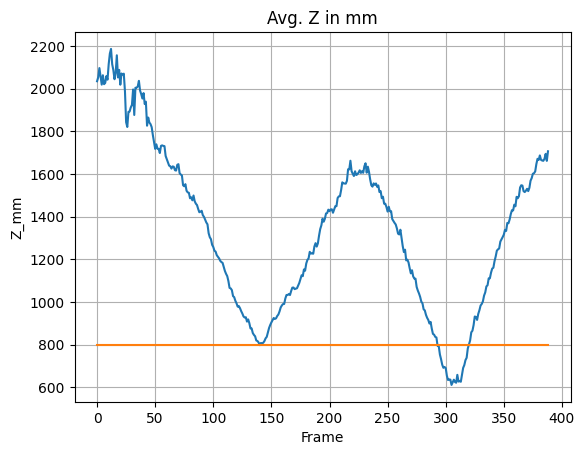

In [ ]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, list_z_mm)
plt.title('Avg. Z in mm')
line = 800*np.ones((len(f_values)))
plt.plot(f_values, line)
plt.xlabel('Frame')
plt.ylabel('Z_mm')
plt.grid(True)
plt.show()

<h2> Trying to measure Chessboard W, H estimates </h2>

In [ ]:
from math import cos

W_mm_list = []
H_mm_list = []
W_mm_diff = []
H_mm_diff = []
w_px_list = []
h_px_list = []
for frame in range(number_of_frames):
    if list_foundL[frame] and list_foundR[frame]:
        w_px = 0
        h_px = 0
        for w_line in range(8):
            w_px_R = list_cornersR[frame][6*w_line+5][0][0]-list_cornersR[frame][6*w_line+0][0][0]
            w_px_L = list_cornersL[frame][6*w_line+5][0][0]-list_cornersL[frame][6*w_line+0][0][0]
            w_px = w_px+w_px_L+w_px_R
        for h_line in range(6):
            h_px_R = list_cornersR[frame][42+h_line][0][1]-list_cornersR[frame][0+h_line][0][1]
            h_px_L = list_cornersL[frame][42+h_line][0][1]-list_cornersL[frame][0+h_line][0][1]
            h_px = h_px+h_px_L+h_px_R
       
        w_px = w_px/16
        h_px = h_px/12
        W_mm = w_px*list_z_mm[frame]/(f*cos(pi*(tau_mean/180)))     
        H_mm = h_px*list_z_mm[frame]/(f*cos(pi*list_tau[frame]/180))   
        w_px_list.append(w_px)
        h_px_list.append(h_px) 
        W_mm_diff.append(W_mm-125)
        H_mm_diff.append(H_mm-175)
    else:
        w_px_list.append(None)
        h_px_list.append(None)
        W_mm_diff.append(None)
        H_mm_diff.append(None)
    

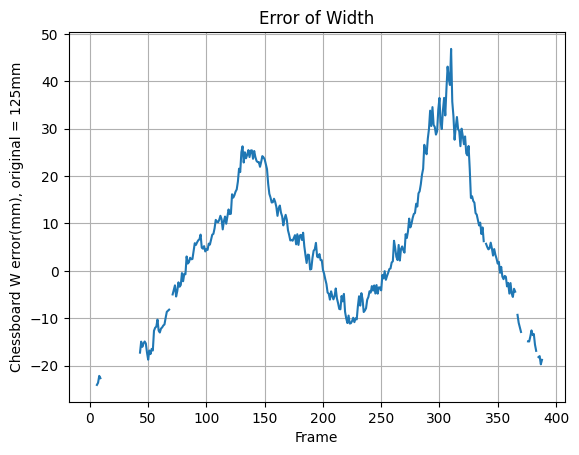

In [ ]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, W_mm_diff)
plt.title('Error of Width')
plt.xlabel('Frame')
plt.ylabel('Chessboard W error(mm), original = 125mm')
plt.grid(True)
plt.show()

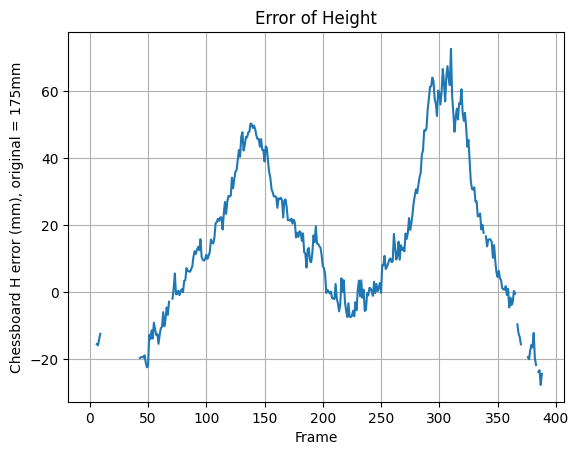

In [ ]:
# Plotting
f_values = list(range(number_of_frames))
plt.plot(f_values, H_mm_diff)
plt.title('Error of Height')
plt.xlabel('Frame')
plt.ylabel('Chessboard H error (mm), original = 175mm')
plt.grid(True)
plt.show()

<h2> What we can do? </h2>

We have the result already. Which is pretty okay but can be improved (maybe?)

1. Use (Moravec) corner detection to find correspondence points.
2. Use disparity ranges to calculate disparities. 
3. Vertical Slicing of image with different disparities.
4. Alarm sounding below 0.8m.

